In [1]:
import time

import numpy as np
from numpy import random

from pathlib import Path

import cv2

import torch
from torch import nn, Tensor

from models.yolo import yolov5_darknet_pan_s_r31 as yolov5s

from utils.image_utils import (cv2_imshow, color_list, read_image, letterbox, scale_coords,
                               plot_one_box, load_names, overlay_boxes)

In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

device = torch.device('cuda')

## Model Definition and Initialization

In [3]:
model = yolov5s(pretrained=True, score_thresh=0.25)

In [4]:
model.eval()
model = model.to(device)

## Add Parameters for Model and Detection

In [5]:
# half = device.type != 'cpu'  # half precision only supported on CUDA
is_half = False

# Load model
if is_half:
    model.half()  # to FP16

# Run inference on dummy input
img_dummy = torch.zeros((1, 3, 416, 416), device=device)  # init img
_ = model(img_dummy)

In [6]:
path = 'test/assets/bus.jpg'

In [7]:
img_raw = cv2.imread(path)
img = letterbox(img_raw, new_shape=416)[0]
img = read_image(img, is_half)
img = img.to(device)

In [8]:
with torch.no_grad():
    t1 = time.time()
    model_out = model(img[None])
    time_consumed = time.time() - t1

## Varify the Inference Output in `pytorch` backend

In [9]:
model_out[0]['boxes'].cpu().detach()

tensor([[ 23.0477, 151.6536,  92.1748, 345.9595],
        [ 10.2298,  87.5519, 314.1234, 279.5108],
        [ 86.6300, 156.0930, 138.0183, 331.3305],
        [260.2261, 144.2707, 317.8065, 335.2532]])

*Target outputs of boxes (yolov5s, with shape of 416x320):*

```
tensor([[ 23.0477, 151.6536,  92.1748, 345.9595],
        [ 10.2298,  87.5519, 314.1234, 279.5108],
        [ 86.6300, 156.0930, 138.0183, 331.3305],
        [260.2261, 144.2707, 317.8065, 335.2532]])
```

*Target outputs of boxes (yolov5m, with shape of 416x320, sample at index 0, length: 5):*

```
[ 23.59163, 153.30780,  98.95451, 348.28122]
```

*Target outputs of boxes (yolov5l, with shape 416x320, sample at index 0, length: 5):*

```
[ 23.83324, 151.75786,  98.95541, 349.06909]
```

In [10]:
model_out[0]['scores'].cpu().detach()

tensor([0.8927, 0.8781, 0.8357, 0.7878])

*Target outputs of scores: (`yolov5s`, with shape of 416x320)*

```
[0.8927, 0.8781, 0.8357, 0.7878]
```

*Target outputs of scores: (`yolov5m`, with shape of 416x320)*

```
[0.9057, 0.8703, 0.8602, 0.8408, 0.3821]
```

*Target outputs of scores: (`yolov5l`, with shape of 416x320)*

```
[0.9133, 0.9064, 0.8761, 0.8255, 0.5877]
```

In [11]:
model_out[0]['labels'].cpu().detach()

tensor([0, 5, 0, 0])

*Target outputs of labels:*

```
tensor([0, 5, 0, 0])
```

## Detection output visualisation

In [12]:
img_shape = img.shape[1:]
img_shape_origin = img_raw.shape[:2]
boxes = scale_coords(model_out[0]['boxes'], img_shape, img_shape_origin)

In [13]:
colors = color_list()

for box, label in zip(boxes.tolist(), model_out[0]['labels'].tolist()):
    img_raw = plot_one_box(box, img_raw, color=colors[label % len(colors)])

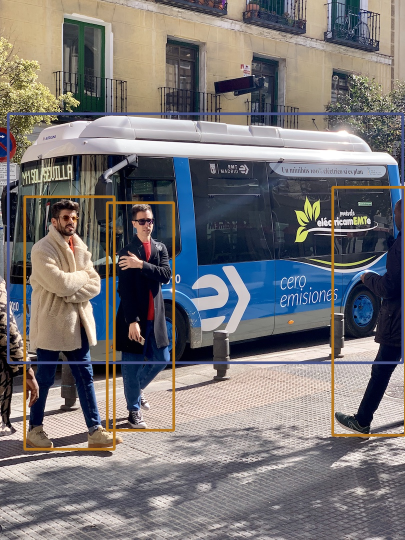

In [14]:
imshow_scale = 0.5
cv2_imshow(cv2.resize(img_raw, None, fx=imshow_scale, fy=imshow_scale))

## Export to torchscript model

In [15]:
# TorchScript export
print(f'Starting TorchScript export with torch {torch.__version__}...')
export_script_name = './checkpoints/yolov5/yolov5s.torchscript.pt'  # filename

Starting TorchScript export with torch 1.7.1...


In [16]:
model_script = torch.jit.script(model)
model_script.eval()
model_script = model_script.to(device)

## Inference on `torchscript` Backend

In [17]:
x = img[None]
out = model(x)
out_script = model_script(x)

/data/wangzq/yolov5-rt-stack/models/yolo.py:119: UserWarning: YOLO always returns a (Losses, Detections) tuple in scripting
  warnings.warn("YOLO always returns a (Losses, Detections) tuple in scripting")


## Varify the Inference Output in `libtorch` backend

In [18]:
for k, v in out[0].items():
    torch.testing.assert_allclose(out_script[1][0][k], v, rtol=1e-07, atol=1e-09)

print("Exported model has been tested with libtorch, and the result looks good!")

Exported model has been tested with libtorch, and the result looks good!


### Comparing Inference Time between `pytorch` and `libtorch`

**Time consumed on `pytorch` backend**

In [19]:
%%time
with torch.no_grad():
    out = model(x)

CPU times: user 12 ms, sys: 4 ms, total: 16 ms
Wall time: 15.4 ms


**Time consumed on `libtorch` backend**

In [20]:
# Dummy run once for torchscript
with torch.no_grad():
    out_script = model_script(x)

In [21]:
%%time
with torch.no_grad():
    out_script = model_script(x)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 8.71 ms
